In [1]:
import os
import pandas as pd
import tensorflow as tf
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D, Concatenate, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from utils import eval, eval_training, get_train_test_data

os.environ['TF_NUM_INTEROP_THREADS'] = '10'
os.environ['TF_NUM_INTRAOP_THREADS'] = '10'

# Configure TensorFlow session for multi-threading
tf.config.threading.set_inter_op_parallelism_threads(10)
tf.config.threading.set_intra_op_parallelism_threads(10)
# Ensure TensorFlow is using the Metal backend
gpu = len (tf.config.list_physical_devices ('GPU'))>0
print ("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


Training set size: 27154
Validation set size: 9051
Test set size: 9052
label
meniskus_urgent    11064
other               9523
cruciate_urgent     3882
meniskus_low        1549
other_urgent         905
cruciate_low         231
Name: count, dtype: int64


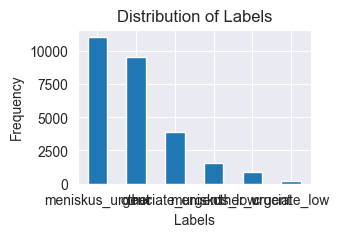

In [2]:
data_label = "data"
predict_label = "label"
balanced = False
labels = None
class_weights = True
sample_weights = True
df = pd.read_csv('../data/balanced_classification_dataset.csv')

train_padded, valid_padded, test_padded, train_labels, valid_labels, test_labels, label_encoder, num_classes, max_length, word_index, class_weights, sample_weights = get_train_test_data(df, data_label, predict_label, balanced=balanced, lables=labels, class_weights=class_weights, sample_weights=sample_weights)

In [3]:
embedding_dim = 300  # Dimension of the embedding vectors
lstm_units = 64
epochs = 10
batch_size = 32

# Baseline

In [4]:
# Define model parameters
optimizer = Adam()
loss = tf.keras.losses.CategoricalCrossentropy()
metrics=[
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.F1Score(name='f1_score'),
]

2024-07-21 15:21:14.066478: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-07-21 15:21:14.066527: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-07-21 15:21:14.066558: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-07-21 15:21:14.066601: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-21 15:21:14.066631: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(embedding)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(units=lstm_units))(embedding)



# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model_base = Model(inputs=input_text, outputs=output)

# Compile the model
model_base.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [6]:
history_base = model_base.fit(train_padded, train_labels, epochs=epochs, batch_size=batch_size,
                    validation_data=(valid_padded, valid_labels))

Epoch 1/10


2024-07-21 15:21:15.301205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


849/849 ━━━━━━━━━━━━━━━━━━━━ 104s 116ms/step - accuracy: 0.5017 - auc: 0.8534 - f1_score: 0.2557 - loss: 1.1849 - val_accuracy: 0.5711 - val_auc: 0.8790 - val_f1_score: 0.3085 - val_loss: 1.0912
Epoch 2/10
849/849 ━━━━━━━━━━━━━━━━━━━━ 96s 114ms/step - accuracy: 0.6292 - auc: 0.9023 - f1_score: 0.3670 - loss: 0.9842 - val_accuracy: 0.6092 - val_auc: 0.8966 - val_f1_score: 0.3667 - val_loss: 1.0120
Epoch 3/10
849/849 ━━━━━━━━━━━━━━━━━━━━ 99s 116ms/step - accuracy: 0.6925 - auc: 0.9267 - f1_score: 0.4399 - loss: 0.8505 - val_accuracy: 0.5825 - val_auc: 0.8854 - val_f1_score: 0.3435 - val_loss: 1.0697
Epoch 4/10
849/849 ━━━━━━━━━━━━━━━━━━━━ 99s 117ms/step - accuracy: 0.7165 - auc: 0.9395 - f1_score: 0.4956 - loss: 0.7726 - val_accuracy: 0.5973 - val_auc: 0.8879 - val_f1_score: 0.3564 - val_loss: 1.0884
Epoch 5/10
849/849 ━━━━━━━━━━━━━━━━━━━━ 101s 120ms/step - accuracy: 0.7658 - auc: 0.9562 - f1_score: 0.5604 - loss: 0.6548 - val_accuracy: 0.5628 - val_auc: 0.8731 - val_f1_score: 0.3660 - v

# Using class weights

In [10]:
# Define model parameters
optimizer = Adam()
loss = tf.keras.losses.CategoricalCrossentropy()
metrics=[
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.F1Score(name='f1_score'),
]

In [11]:
# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(embedding)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(units=lstm_units))(embedding)



# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model_class = Model(inputs=input_text, outputs=output)

# Compile the model
model_class.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [14]:
history_class = model_class.fit(train_padded, train_labels, epochs=epochs, batch_size=batch_size,
                    validation_data=(valid_padded, valid_labels), class_weight=class_weights)

Epoch 1/10
849/849 ━━━━━━━━━━━━━━━━━━━━ 98s 114ms/step - accuracy: 0.4983 - auc: 0.8505 - f1_score: 0.2521 - loss: 1.1962 - val_accuracy: 0.5937 - val_auc: 0.8879 - val_f1_score: 0.3195 - val_loss: 1.0550
Epoch 2/10
849/849 ━━━━━━━━━━━━━━━━━━━━ 97s 114ms/step - accuracy: 0.6308 - auc: 0.9049 - f1_score: 0.3521 - loss: 0.9702 - val_accuracy: 0.5989 - val_auc: 0.8927 - val_f1_score: 0.3428 - val_loss: 1.0309
Epoch 3/10
849/849 ━━━━━━━━━━━━━━━━━━━━ 94s 111ms/step - accuracy: 0.6742 - auc: 0.9220 - f1_score: 0.4171 - loss: 0.8789 - val_accuracy: 0.6146 - val_auc: 0.8960 - val_f1_score: 0.3692 - val_loss: 1.0305
Epoch 4/10
849/849 ━━━━━━━━━━━━━━━━━━━━ 95s 112ms/step - accuracy: 0.7154 - auc: 0.9394 - f1_score: 0.4869 - loss: 0.7727 - val_accuracy: 0.6006 - val_auc: 0.8885 - val_f1_score: 0.3573 - val_loss: 1.1116
Epoch 5/10
849/849 ━━━━━━━━━━━━━━━━━━━━ 179s 210ms/step - accuracy: 0.7673 - auc: 0.9572 - f1_score: 0.5677 - loss: 0.6442 - val_accuracy: 0.5856 - val_auc: 0.8766 - val_f1_score: 

# Sample Weights

In [15]:
# Define model parameters
optimizer = Adam()
loss = tf.keras.losses.CategoricalCrossentropy()
metrics=[
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.F1Score(name='f1_score'),
]

In [16]:
# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(embedding)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(units=lstm_units))(embedding)



# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model_sample = Model(inputs=input_text, outputs=output)

# Compile the model
model_sample.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [17]:
history_sample = model_sample.fit(train_padded, train_labels, epochs=epochs, batch_size=batch_size,
                    validation_data=(valid_padded, valid_labels), sample_weight=sample_weights)

Epoch 1/10
849/849 ━━━━━━━━━━━━━━━━━━━━ 224s 257ms/step - accuracy: 0.5006 - auc: 0.8536 - f1_score: 0.2492 - loss: 1.1859 - val_accuracy: 0.6070 - val_auc: 0.8930 - val_f1_score: 0.3215 - val_loss: 1.0298
Epoch 2/10
849/849 ━━━━━━━━━━━━━━━━━━━━ 208s 245ms/step - accuracy: 0.6387 - auc: 0.9069 - f1_score: 0.3640 - loss: 0.9603 - val_accuracy: 0.6045 - val_auc: 0.8953 - val_f1_score: 0.3417 - val_loss: 1.0183
Epoch 3/10
849/849 ━━━━━━━━━━━━━━━━━━━━ 78s 92ms/step - accuracy: 0.6867 - auc: 0.9281 - f1_score: 0.4382 - loss: 0.8430 - val_accuracy: 0.6006 - val_auc: 0.8908 - val_f1_score: 0.3660 - val_loss: 1.0427
Epoch 4/10
849/849 ━━━━━━━━━━━━━━━━━━━━ 76s 89ms/step - accuracy: 0.7241 - auc: 0.9419 - f1_score: 0.5119 - loss: 0.7569 - val_accuracy: 0.5914 - val_auc: 0.8862 - val_f1_score: 0.3737 - val_loss: 1.0979
Epoch 5/10
849/849 ━━━━━━━━━━━━━━━━━━━━ 76s 90ms/step - accuracy: 0.7718 - auc: 0.9577 - f1_score: 0.5696 - loss: 0.6397 - val_accuracy: 0.5847 - val_auc: 0.8771 - val_f1_score: 0.

# Evaluation

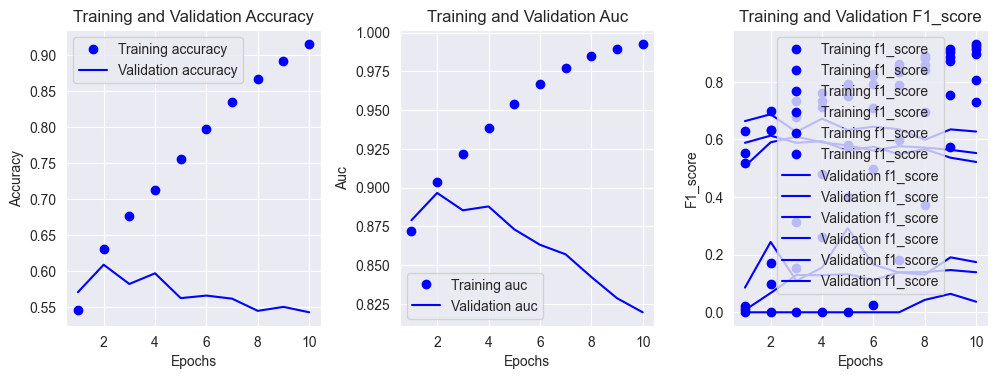

283/283 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step


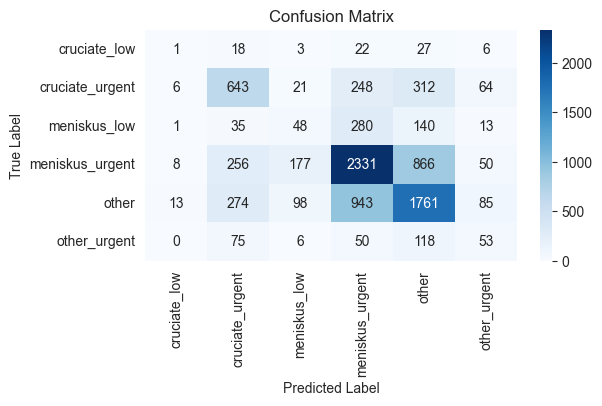

F1: 0.5343570481661511


In [18]:
eval_training(history_base, metrics)
eval(model_base, test_padded, test_labels, label_encoder)

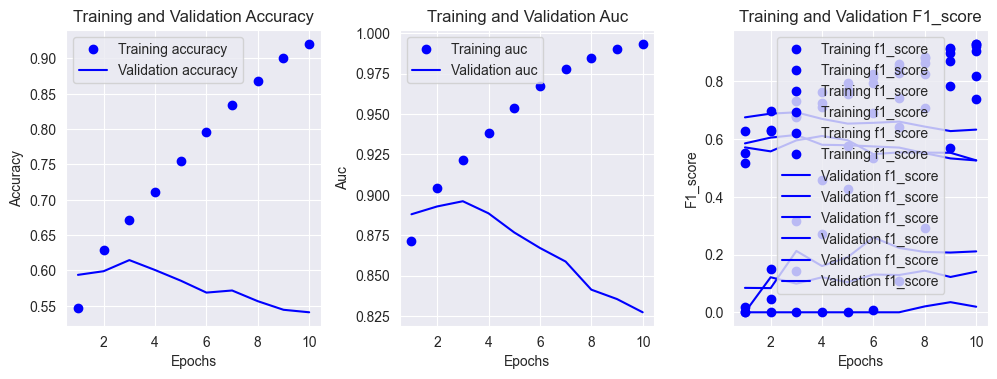

283/283 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step


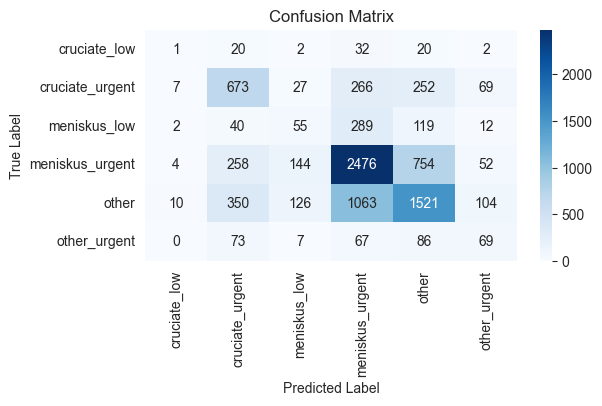

F1: 0.5297171895713655


In [19]:
eval_training(history_class, metrics)
eval(model_class, test_padded, test_labels, label_encoder)

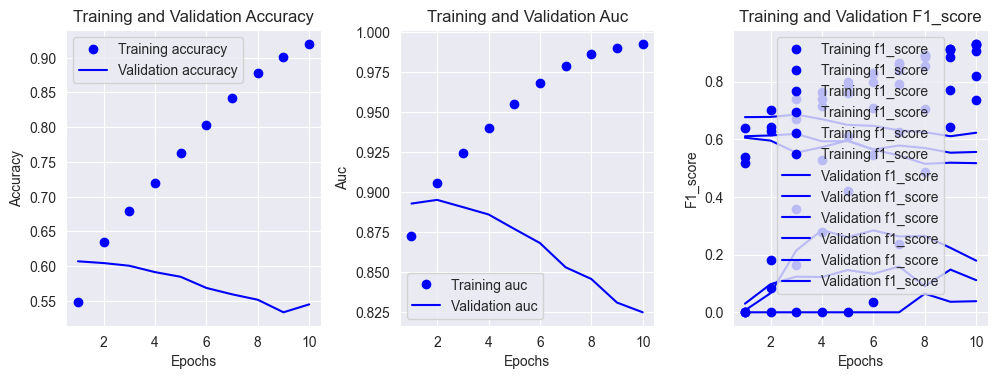

283/283 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step


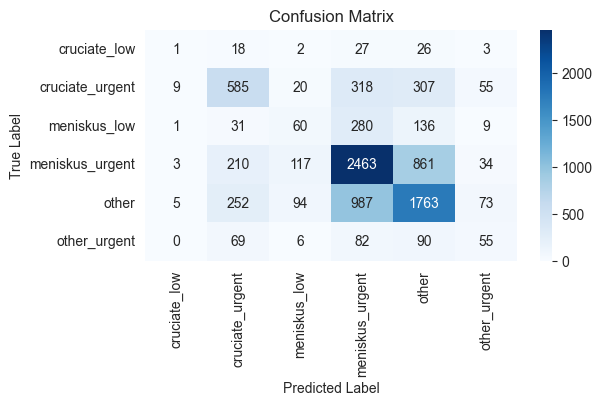

F1: 0.5442996022978347


In [20]:
eval_training(history_sample, metrics)
eval(model_sample, test_padded, test_labels, label_encoder)